# Video Recognition

Project on video recognition whith the dataset HMDB51 (https://serre.lab.brown.edu/hmdb51.html). A special focus is given to the efficiency of the training.

Training finora (loss bilanciata):
- 2 epoche lr=5e-4 FRAME RATE A 3
- 5 epoche lr=1e-4 FRAME RATE A 3 Accuracy: 17.63% Training | 13.51% Test
- 3 epoche kr=5e-5 FRAME RATE A 3 Accuracy: 19.91% Training | 17.73% Test v1
- 5 epoche kr=5e-5 FRAME RATE A 3 Accuracy: 26.61% Training |  22.97% Test v2
- 5 epoche kr=1e-5 FRAME RATE A 1 Accuracy: 28.82% Training |  24.21% Test v3

FRAME RATE 3 => Circa 1h40min per epoca
FRAME RATE 1 => Circa 2h10min per epoca
IDEA: FARE UN PO' DI EPOCHE CON FRAME RATE ALTO E POI ABBASSARLO ALLA FINE

Fine tuning:
- 10 epoche lr=1e-4 solo head


In [290]:
# !pip install opencv-python

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import pickle

# Import everything from your new file
from video_recognition import (
    VideoLoader, CNN, CNNLSTM, train, save_model, load_model, 
    replace_head_for_finetuning, MAX_POOL, get_persistent_splits
)

dataset_directory = "./dataset"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
FRAME_SIZE = 224
FRAME_RATE_SCALER = 3
BATCH_SIZE = 1
ACCUM_STEPS = 20
EMBEDDING_DIM = 256
LSTM_HIDDEN = 128
LSTM_LAYERS = 1
USE_WEIGHTED_LOSS=True
LEARNING_RATE = 5e-4

cnn_config = [
    {'out_channels': 16, 'kernel_size': 3, 'stride': 1, 'padding': 1},
    {'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1},
    {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1},
    {'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1}
]

In [7]:
# 1. Load ENTIRE dataset
full_dataset = VideoLoader(dataset_directory, FRAME_SIZE, FRAME_RATE_SCALER, classes_to_use=None)

# 2. Get Persistent Split (Will create 'pretrain_full_train.pkl' and 'pretrain_full_test.pkl')
full_train, full_test = get_persistent_splits(full_dataset, 0.8, "pretrain_full")

train_loader = DataLoader(full_train, batch_size=BATCH_SIZE, shuffle=True)

# 3. Initialize Model
cnn = CNN(cnn_config, MAX_POOL, (3, FRAME_SIZE, FRAME_SIZE), EMBEDDING_DIM)
model = CNNLSTM(cnn, len(full_dataset.classes), LSTM_HIDDEN, LSTM_LAYERS).to(device)

# 4. Train
print(f"Pre-training on {len(full_dataset.classes)} classes...")
train(model, epochs=1, accumulation_steps=ACCUM_STEPS, learning_rate=LEARNING_RATE, train_loader=train_loader, device=device, use_weighted_loss=USE_WEIGHTED_LOSS)

# 5. Save Master Model
save_model(model, "trained_on_all_classes.pkl")

Classes loaded: ['clap', 'climb', 'climb_stairs', 'dive', 'draw_sword', 'dribble', 'drink', 'eat', 'fall_floor', 'fencing', 'flic_flac', 'golf', 'handstand', 'hit', 'hug', 'jump', 'kick', 'kick_ball', 'kiss', 'laugh', 'pick', 'pour', 'pullup', 'punch', 'push', 'pushup', 'ride_bike', 'ride_horse', 'run', 'shake_hands', 'shoot_ball', 'shoot_bow', 'shoot_gun', 'sit', 'situp', 'smile', 'smoke', 'somersault', 'stand', 'swing_baseball', 'sword', 'sword_exercise', 'talk', 'throw', 'turn', 'walk', 'wave']
Database size: 6341
Loading existing split from pretrain_full...
Pre-training on 47 classes...
Calculating class weights for Weighted Loss...
Class Weights (Shape torch.Size([47])): tensor([1.0685, 1.1859, 1.1480, 1.1604, 1.1859, 0.9303, 0.8175, 1.3002, 0.9722,
        1.1241, 1.2404, 1.3835, 1.2125, 1.0685, 1.1859, 0.8431, 0.9810, 1.0900,
        1.3323, 1.0477, 1.1991, 1.2548, 1.3660, 1.0685, 1.1241, 1.3835, 1.3160,
        1.1604, 0.5563, 0.8993, 1.0086, 1.3160, 1.2125, 0.9900, 1.2548, 1.3

## Test

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import torch
from torch.utils.data import DataLoader
from video_recognition import load_model 

# --- 1. CONFIGURATION ---
MODEL_FILE = "trained_on_all_classes_v3.pkl"
TEST_SET_FILE = "pretrain_full_test.pkl"
BATCH_SIZE = 1 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. LOAD DATA & MODEL ---
print(f"Loading Test Set from {TEST_SET_FILE}...")
with open(TEST_SET_FILE, 'rb') as f:
    test_set = pickle.load(f)

# Get the list of ALL 51 classes
CLASSES = test_set.dataset.classes 
print(f"Evaluating on {len(CLASSES)} classes.")

test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"Loading Master Model from {MODEL_FILE}...")
model = load_model(MODEL_FILE)
model = model.to(device)
model.eval() 

# --- 3. RUN INFERENCE ---
all_preds = []
all_labels = []
print("Running Inference...")

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 4. REPORTING ---
print("\n" + "="*40)
print("MASTER MODEL CLASSIFICATION REPORT")
print("="*40)

# --- FIX: Explicitly pass the range of labels to handle missing classes ---
all_possible_labels = range(len(CLASSES))

print(classification_report(
    all_labels, 
    all_preds, 
    labels=all_possible_labels,  # <--- FIX IS HERE
    target_names=CLASSES, 
    zero_division=0
))

acc = accuracy_score(all_labels, all_preds)
print(f"Total Accuracy: {acc*100:.2f}%")
print("="*40 + "\n")

Loading Test Set from pretrain_full_test.pkl...
Evaluating on 47 classes.
Loading Master Model from trained_on_all_classes_v3.pkl...
Running Inference...

MASTER MODEL CLASSIFICATION REPORT
                precision    recall  f1-score   support

          clap       0.00      0.00      0.00        29
         climb       0.17      0.18      0.17        17
  climb_stairs       0.50      0.17      0.25        18
          dive       0.75      0.09      0.16        34
    draw_sword       0.19      0.42      0.26        12
       dribble       0.32      0.72      0.44        29
         drink       0.00      0.00      0.00        32
           eat       0.00      0.00      0.00        25
    fall_floor       0.50      0.04      0.07        25
       fencing       0.89      0.40      0.55        20
     flic_flac       0.00      0.00      0.00        20
          golf       0.29      0.41      0.34        27
     handstand       0.43      0.12      0.19        24
           hit       0.22

## Continue Training

In [ ]:
# --- 1. CONFIGURATION ---
MORE_EPOCHS = 2
LEARNING_RATE = 1e-5
ACCUM_STEPS = 20
BATCH_SIZE = 1
FRAME_RATE_SCALER = 1
USE_WEIGHTED_LOSS = True

TRAIN_SET_FILE = "pretrain_full_train.pkl" # The full training set
MODEL_FILE = "trained_on_all_classes_v3.pkl"

# --- 2. LOAD DATA & MODEL ---
print(f"Loading Train Set from {TRAIN_SET_FILE}...")
with open(TRAIN_SET_FILE, 'rb') as f:
    train_set = pickle.load(f)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

print(f"Loading Master Model from {MODEL_FILE}...")
from video_recognition import load_model, train, save_model
model = load_model(MODEL_FILE)
model = model.to(device)

# --- 3. RESUME TRAINING ---
print(f"Resuming Master Model training for {MORE_EPOCHS} more epochs...")
train(model, epochs=MORE_EPOCHS, accumulation_steps=ACCUM_STEPS, learning_rate=LEARNING_RATE, train_loader=train_loader, device=device, use_weighted_loss=USE_WEIGHTED_LOSS)

# --- 4. SAVE ---
save_model(model, "trained_on_all_classes_v3.pkl")
print("Updated Master Model saved.")

Loading Train Set from pretrain_full_train.pkl...
Loading Master Model from trained_on_all_classes_v3.pkl...
Resuming Master Model training for 2 more epochs...
Calculating class weights for Weighted Loss...
Class Weights (Shape torch.Size([47])): tensor([1.0685, 1.1859, 1.1480, 1.1604, 1.1859, 0.9303, 0.8175, 1.3002, 0.9722,
        1.1241, 1.2404, 1.3835, 1.2125, 1.0685, 1.1859, 0.8431, 0.9810, 1.0900,
        1.3323, 1.0477, 1.1991, 1.2548, 1.3660, 1.0685, 1.1241, 1.3835, 1.3160,
        1.1604, 0.5563, 0.8993, 1.0086, 1.3160, 1.2125, 0.9900, 1.2548, 1.3323,
        1.3002, 0.9466, 0.8633, 0.9303, 1.0376, 1.1012, 1.0791, 1.4583, 0.5833,
        0.2409, 1.4015])
Epoch 1 Step [20/5072] Loss: 2.8876
Epoch 1 Step [40/5072] Loss: 2.9556
Epoch 1 Step [60/5072] Loss: 2.1816
Epoch 1 Step [80/5072] Loss: 2.7428
Epoch 1 Step [100/5072] Loss: 2.6394
Epoch 1 Step [120/5072] Loss: 2.9346
Epoch 1 Step [140/5072] Loss: 3.1019
Epoch 1 Step [160/5072] Loss: 2.7486
Epoch 1 Step [180/5072] Loss: 2.549

# Fine Tune

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter


TARGET_CLASSES = ['golf', 'dribble', 'swing_baseball', 'shoot_bow', 'kick_ball']
MODEL_FILE_FINE = "finetuned_model_sports.pkl"
MODEL_FILE = "trained_on_all_classes_v3.pkl"
FINE_TUNE_EPOCHS=10
LEARNING_RATE = 1e-4
ACCUM_STEPS = 15
FRAME_SIZE = 224
FRAME_RATE_SCALER = 1
BATCH_SIZE = 1
USE_WEIGHTED_LOSS = True

model = load_model(MODEL_FILE) 

print("Old Head:", model.fc)

for param in model.parameters():
    param.requires_grad = False
input_features = model.fc.in_features 

num_target_classes = len(TARGET_CLASSES) 
model.fc = nn.Linear(input_features, num_target_classes)

print(f"New Head: {model.fc}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)

# Create Dataset
subset_dataset = VideoLoader(dataset_directory, FRAME_SIZE, FRAME_RATE_SCALER, classes_to_use=TARGET_CLASSES)

# Split (sub_train is a torch.utils.data.Subset object)
sub_train, sub_test = get_persistent_splits(subset_dataset, 0.8, "finetune_subset")

sub_loader = DataLoader(sub_train, batch_size=BATCH_SIZE, shuffle=True)

train_indices = sub_train.indices
all_labels = [subset_dataset.db[i][1] for i in train_indices]

class_counts = Counter(all_labels)
print("Class Distribution:", class_counts)

sorted_counts = [class_counts[cls_name] for cls_name in subset_dataset.classes]

total_samples = sum(sorted_counts)
num_classes = len(subset_dataset.classes)

weights = [total_samples / (num_classes * count) for count in sorted_counts]
class_weights = torch.FloatTensor(weights).to(device)

print(f"Computed Class Weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights)

print(f"Fine-tuning for {TARGET_CLASSES}...")
print("Starting Phase 1 Training (Head Only)...")

for epoch in range(FINE_TUNE_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    interval_loss = 0.0
    
    optimizer.zero_grad()
    
    # --- FIX 4: Loop over 'sub_loader', not 'train_loader' ---
    for i, (inputs, labels) in enumerate(sub_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Accumulate gradients
        loss = loss / ACCUM_STEPS
        loss.backward()
        
        if (i + 1) % ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()
            
        # Stats
        loss_val = loss.item() * ACCUM_STEPS
        running_loss += loss_val
        interval_loss += loss_val
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i+1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{FINE_TUNE_EPOCHS}] Step [{i+1}] Avg Loss: {interval_loss/50:.4f}")
            interval_loss = 0.0

    epoch_acc = 100 * correct / total
    avg_loss = running_loss / len(sub_loader)
    
    print(f"Epoch {epoch+1} Complete | Loss: {avg_loss:.4f} | Acc: {epoch_acc:.2f}%")

# Save Final Model
save_model(model, MODEL_FILE_FINE)

Old Head: Linear(in_features=128, out_features=47, bias=True)
New Head: Linear(in_features=128, out_features=5, bias=True)
Classes loaded: ['dribble', 'golf', 'kick_ball', 'shoot_bow', 'swing_baseball']
Database size: 633
Loading existing split from finetune_subset...
Class Distribution: Counter({'swing_baseball': 124, 'dribble': 117, 'kick_ball': 100, 'shoot_bow': 86, 'golf': 79})
Computed Class Weights: tensor([0.8650, 1.2810, 1.0120, 1.1767, 0.8161])
Fine-tuning for ['golf', 'dribble', 'swing_baseball', 'shoot_bow', 'kick_ball']...
Starting Phase 1 Training (Head Only)...
Epoch [1/10] Step [50] Avg Loss: 1.8105
Epoch [1/10] Step [100] Avg Loss: 1.6763
Epoch [1/10] Step [150] Avg Loss: 1.6952
Epoch [1/10] Step [200] Avg Loss: 1.6395
Epoch [1/10] Step [250] Avg Loss: 1.7471
Epoch [1/10] Step [300] Avg Loss: 1.6082
Epoch [1/10] Step [350] Avg Loss: 1.5524
Epoch [1/10] Step [400] Avg Loss: 1.7577
Epoch [1/10] Step [450] Avg Loss: 1.5533
Epoch [1/10] Step [500] Avg Loss: 1.6595
Epoch 1 C

Loading Test Set from finetune_subset_test.pkl...
Loading Model from finetuned_model_sports.pkl...
Running Inference...

FINAL CLASSIFICATION REPORT
                precision    recall  f1-score   support

          golf       0.57      0.89      0.69        28
       dribble       0.59      0.38      0.47        26
swing_baseball       0.56      0.32      0.41        28
     shoot_bow       0.65      0.50      0.57        26
     kick_ball       0.37      0.58      0.45        19

      accuracy                           0.54       127
     macro avg       0.55      0.54      0.52       127
  weighted avg       0.56      0.54      0.52       127

Total Accuracy: 53.54%



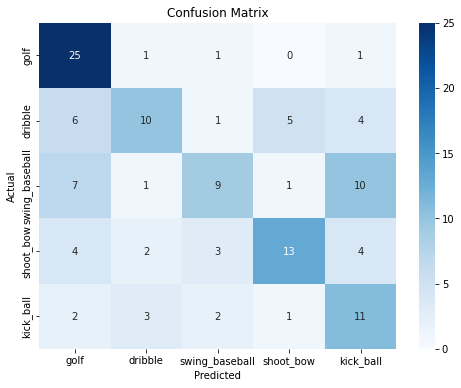

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
from torch.utils.data import DataLoader

# --- 1. CONFIGURATION ---
TEST_SET_FILE = "finetune_subset_test.pkl"
BATCH_SIZE = 1 # Keep at 1 for precise video-by-video evaluation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. LOAD DATA & MODEL ---
print(f"Loading Test Set from {TEST_SET_FILE}...")
with open(TEST_SET_FILE, 'rb') as f:
    test_set = pickle.load(f)

test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print(f"Loading Model from {MODEL_FILE_FINE}...")
# Use the load_model function from your module
from video_recognition import load_model
model = load_model(MODEL_FILE_FINE)
model = model.to(device)
model.eval() # Set to evaluation mode (Important: disables Dropout)

# --- 3. RUN INFERENCE ---
all_preds = []
all_labels = []
print("Running Inference...")

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 4. REPORTING ---
# A. Classification Report (Precision, Recall, F1)
print("\n" + "="*40)
print("FINAL CLASSIFICATION REPORT")
print("="*40)
print(classification_report(all_labels, all_preds, target_names=TARGET_CLASSES, zero_division=0))

# B. Accuracy Score
acc = accuracy_score(all_labels, all_preds)
print(f"Total Accuracy: {acc*100:.2f}%")
print("="*40 + "\n")

# C. Confusion Matrix Plot
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=TARGET_CLASSES, 
            yticklabels=TARGET_CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

CONTINURE FINTUNE TRAINING (HEAD)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter


TARGET_CLASSES = ['golf', 'dribble', 'swing_baseball', 'shoot_bow', 'kick_ball']
MODEL_FILE_FINE = "finetuned_model_sports.pkl"
FINE_TUNE_EPOCHS=5
LEARNING_RATE = 1e-5
ACCUM_STEPS = 15
FRAME_SIZE = 224
FRAME_RATE_SCALER = 1
BATCH_SIZE = 1
USE_WEIGHTED_LOSS = True

model = load_model(MODEL_FILE_FINE) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)

# Create Dataset
subset_dataset = VideoLoader(dataset_directory, FRAME_SIZE, FRAME_RATE_SCALER, classes_to_use=TARGET_CLASSES)

# Split (sub_train is a torch.utils.data.Subset object)
sub_train, sub_test = get_persistent_splits(subset_dataset, 0.8, "finetune_subset")

sub_loader = DataLoader(sub_train, batch_size=BATCH_SIZE, shuffle=True)

train_indices = sub_train.indices
all_labels = [subset_dataset.db[i][1] for i in train_indices]

class_counts = Counter(all_labels)
print("Class Distribution:", class_counts)

sorted_counts = [class_counts[cls_name] for cls_name in subset_dataset.classes]

total_samples = sum(sorted_counts)
num_classes = len(subset_dataset.classes)

weights = [total_samples / (num_classes * count) for count in sorted_counts]
class_weights = torch.FloatTensor(weights).to(device)

print(f"Computed Class Weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights)

print(f"Fine-tuning for {TARGET_CLASSES}...")
print("Starting Phase 1 Training (Head Only)...")

for epoch in range(FINE_TUNE_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    interval_loss = 0.0
    
    optimizer.zero_grad()
    
    # --- FIX 4: Loop over 'sub_loader', not 'train_loader' ---
    for i, (inputs, labels) in enumerate(sub_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Accumulate gradients
        loss = loss / ACCUM_STEPS
        loss.backward()
        
        if (i + 1) % ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()
            
        # Stats
        loss_val = loss.item() * ACCUM_STEPS
        running_loss += loss_val
        interval_loss += loss_val
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (i+1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{FINE_TUNE_EPOCHS}] Step [{i+1}] Avg Loss: {interval_loss/50:.4f}")
            interval_loss = 0.0

    epoch_acc = 100 * correct / total
    avg_loss = running_loss / len(sub_loader)
    
    print(f"Epoch {epoch+1} Complete | Loss: {avg_loss:.4f} | Acc: {epoch_acc:.2f}%")

# Save Final Model
save_model(model, MODEL_FILE_FINE)

CONTINUTE FINETUNE TRAINING (ALL)

In [ ]:
# --- 1. CONFIGURATION ---
MORE_EPOCHS = 5
LEARNING_RATE = 1e-4 # Keep this low for fine-tuning/resuming
ACCUM_STEPS = 20
BATCH_SIZE = 1

TRAIN_SET_FILE = "finetune_subset_train.pkl"
MODEL_FILE_FINE = "finetuned_model_sports.pkl"

# --- 2. LOAD DATA & MODEL ---
print(f"Loading Train Set from {TRAIN_SET_FILE}...")
with open(TRAIN_SET_FILE, 'rb') as f:
    train_set = pickle.load(f)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

print(f"Loading Model from {MODEL_FILE_FINE}...")
from video_recognition import load_model, train, save_model
model = load_model(MODEL_FILE_FINE)
model = model.to(device)

# --- 3. RESUME TRAINING ---
print(f"Resuming training for {MORE_EPOCHS} more epochs...")
train(model, epochs=MORE_EPOCHS, accumulation_steps=ACCUM_STEPS, learning_rate=LEARNING_RATE, train_loader=train_loader, device=device, use_weighted_loss=USE_WEIGHTED_LOSS)

# --- 4. SAVE ---
save_model(model, MODEL_FILE_FINE)
print("Updated model saved.")

Loading Train Set from finetune_subset_train.pkl...
Loading Model from finetuned_model_sports.pkl...


UnpicklingError: invalid load key, '\x00'.

Extra idea, Smoke detector, Ecc

In [9]:
MODEL_FILE

'trained_on_all_classes_v3.pkl'